# import

In [65]:
# | code-fold : true
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

import plotly.express as px

# 데이터 준비 및 이해

In [6]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/advertising.csv'
adv = pd.read_csv(path)

In [9]:
adv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


`-` 모든 feature들이 연속형 변수로 가변수화는 필요없다.

In [10]:
adv.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


`-` x,y 분리

In [7]:
target = "Sales"

x = adv.drop(target, axis = 1)
y = adv[target]

# ML review : linear regreesion

In [11]:
from sklearn.linear_model import LinearRegression

`-` 전과정은 이제 한번에 쓰자.

In [14]:
# step 0. 데이터 셋 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 2023)

# step 1. 모델 선언
lm = LinearRegression()

# step 2. 모델 fit
lm.fit(x_train, y_train)

# step 3. 모델 predict
lm.pred = lm.predict(x_test)

`-` 결과 요약

In [19]:
np.mean(y_test), np.mean(lm.pred)

(13.871666666666668, 14.059021420299166)

In [20]:
np.mean((y_test-lm.pred)**2)

2.417343095034177

`-` 결과 시각화

In [44]:
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

lm.pred_data = pd.concat([x_test,y_test], axis= 1)

lm.pred_data["Sales_pred"] = lm.pred
lm.pred_data.head()

,TV,Radio,Newspaper,Sales,Sales_pred
0,97.5,7.6,7.2,9.7,8.882060
1,286.0,13.9,3.7,15.9,19.000003
2,197.6,3.5,5.9,11.7,12.871302
3,224.0,2.4,15.6,11.6,13.893769
4,193.2,18.4,65.7,15.2,15.273020


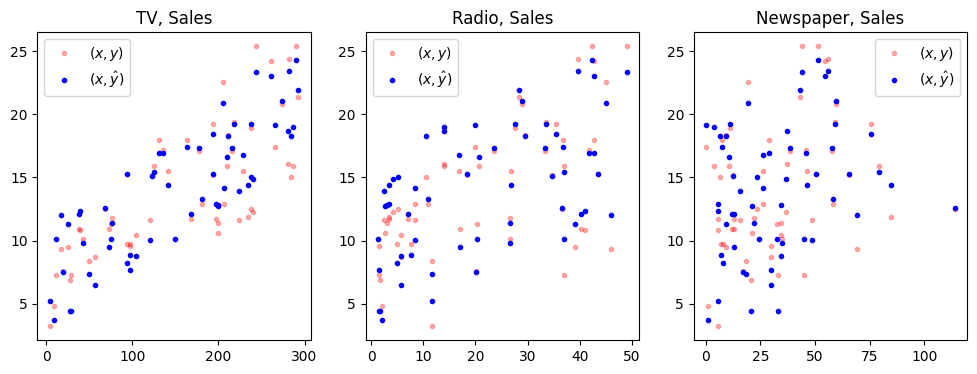

In [64]:
# | code-fold : true
fig, axes = plt.subplots(1,3, figsize =(12,4))

x_col = lm.pred_data.columns[0:3].tolist()
for i in range(3) :
    axes[i].plot(lm.pred_data[x_col[i]], y_test, ".r", label = r"$(x,y)$",alpha=0.3)
    axes[i].plot(lm.pred_data[x_col[i]], lm.pred, ".b", label = r"$(x,\hat y)$")
    axes[i].set_title(x_col[i] + ", Sales")
    axes[i].legend()

`-` 결과 요약

In [66]:
print(f'RMSE  : {mean_squared_error(y_test, lm.pred, squared=False)}')
print(f'MAE   : {mean_absolute_error(y_test, lm.pred)}')
print(f'MAPE  : {mean_absolute_percentage_error(y_test, lm.pred)}')

RMSE  : 1.5547807224924604
MAE   : 1.2573619368638342
MAPE  : 0.11717490489730135


***

# 딥러닝 모델링

## (1) 전처리

In [68]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## (2) import

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

## (3) 모델 선언

In [70]:
n_features = x_train.shape[1] ## 컬럼 개수

In [71]:
# 메모리 정리
clear_session()

# Sequential 타입 모델 선언
model = Sequential(Dense(1, input_shape = (n_features,)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`-` 초기 셋팅된 파라미터 값을 살펴보자.

* 일단 아래와 같은 값으로 기본 셋팅이 되어있다...

In [134]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(3, 1) dtype=float32, numpy=
 array([[ 0.21143973],
        [-0.36714107],
        [ 1.0211834 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

`-` 일단 초기셋팅한값으로 test data를 적합시 얼만큼 잘 예측하는지 시각화 해보자..

In [109]:
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior() ## tnf 를 numpy 처럼 사용할 수 있도록 해줌

`-` 일단 $X$를 우리가 잘 알고 있는 회귀 분석 형태로 바꿔주고 $y_{init}$를 예측

$$\bf \hat {y}_{init} = X \bf{\hat {\beta}_{init}}$$

In [138]:
w_init = np.concatenate([tnp.array(model.weights[1]).reshape(1,1),
                         tnp.array(model.weights[0])],axis = 0)

x_test_matrix = np.concatenate([np.ones(x_test.shape[0]).reshape(-1,1),
                                 x_test],axis = 1)

y_pred_init = x_test_matrix @ w_init

In [139]:
y_pred_init = x_test_matrix @ w_init

`-` 초기값이라 그런지 잘 예측하는 것 같지는 않음

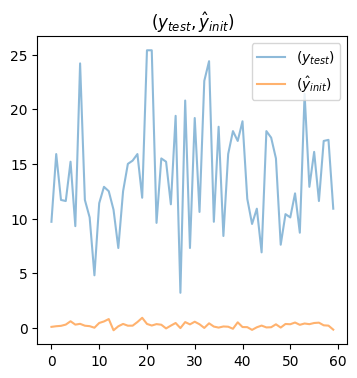

In [147]:
# | code-fold : true
plt.figure(figsize = (4,4))
plt.plot(y_test,label = r"$(y_{test})$",alpha = 0.5)
plt.plot(y_pred_init,label = r"$(\hat {y}_{init})$",alpha = 0.6)
plt.title(r"($y_{test}, \hat {y}_{init}$)")
plt.legend()
plt.show()

`-` 이제 keras에서 제공하는 compile과 fit을 이용하여 모델 적합후 비교해보자

In [148]:
## compile
model.compile(optimizer = "adam", loss = "mse")

## fit
model.fit(x_train, y_train)

5/5 [==============================] - 6s 5ms/step - loss: 219.7330


`-` 예측값 저장 (기본 epoch = 5 이므로 y_pred_5라고 저장)

In [149]:
y_pred_5 = model.predict(x_test)

2/2 [==============================] - 0s 9ms/step


In [152]:
#model.predict?

`-` 여전히 성능이 쓰레기임

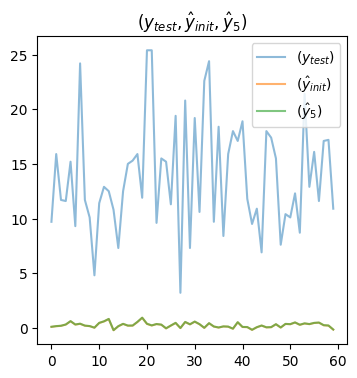

In [153]:
# | code-fold : true
plt.figure(figsize = (4,4))
plt.plot(y_test,label = r"$(y_{test})$",alpha = 0.5)
plt.plot(y_pred_init,label = r"$(\hat {y}_{init})$",alpha = 0.6)
plt.plot(y_pred_5,label = r"$(\hat {y}_{5})$",alpha = 0.6)
plt.title(r"($y_{test}, \hat {y}_{init}, \hat {y}_{5}$)")
plt.legend()
plt.show()

`-` epochs를 늘려서 다시 예측해보자

In [160]:
model.fit?

In [161]:
model.compile?

In [162]:
## compile
model.compile(optimizer = "adam", loss = "mse")

## fit
model.fit(x_train, y_train, epochs = 1000)

y_pred_final = model.predict(x_test,verbose = 0)

Epoch 1/1000
5/5 [==============================] - 1s 6ms/step - loss: 109.4172
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 109.1868
Epoch 3/1000
5/5 [==============================] - 0s 5ms/step - loss: 108.9626
Epoch 4/1000
5/5 [==============================] - 0s 5ms/step - loss: 108.7299
Epoch 5/1000
5/5 [==============================] - 0s 5ms/step - loss: 108.4981
Epoch 6/1000
5/5 [==============================] - 0s 5ms/step - loss: 108.2746
Epoch 7/1000
5/5 [==============================] - 0s 5ms/step - loss: 108.0486
Epoch 8/1000
5/5 [==============================] - 0s 7ms/step - loss: 107.8185
Epoch 9/1000
5/5 [==============================] - 0s 7ms/step - loss: 107.6013
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 107.3712
Epoch 11/1000
5/5 [==============================] - 0s 5ms/step - loss: 107.1475
Epoch 12/1000
5/5 [==============================] - 0s 5ms/step - loss: 106.9191
Epoch 13/1000
5/5 [======

`-` epoch을 1000번쯤 셋팅하니 잘 예측한다..

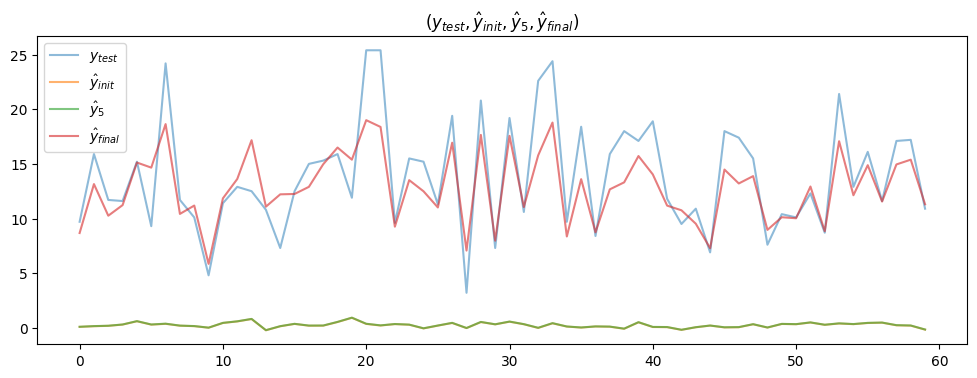

In [165]:
# | code-fold : true
plt.figure(figsize = (12,4))
plt.plot(y_test,label = r"$y_{test}$",alpha = 0.5)
plt.plot(y_pred_init,label = r"$\hat {y}_{init}$",alpha = 0.6)
plt.plot(y_pred_5,label = r"$\hat {y}_{5}$",alpha = 0.6)
plt.plot(y_pred_final,label = r"$\hat {y}_{final}$",alpha = 0.6)
plt.title(r"($y_{test}, \hat {y}_{init}, \hat {y}_{5},\hat {y}_{final}$)")
plt.legend()
plt.show()

`-` 검증해보자

*  검증결과 이런 간단한 회귀 문제는 시간을 들여서 딥러닝 모델을 사용할 필요가 없어보인다.

* 비교해보니, 걸리는 시간은 딥러닝 모델이 훨씬 길고, 예측 성능도 떨어진다.

In [168]:
print("ML model")
print(f'RMSE  : {mean_squared_error(y_test, lm.pred, squared=False)}')
print(f'MAE   : {mean_absolute_error(y_test, lm.pred)}')
print(f'MAPE  : {mean_absolute_percentage_error(y_test, lm.pred)}')

ML model
RMSE  : 1.5547807224924604
MAE   : 1.2573619368638342
MAPE  : 0.11717490489730135


In [169]:
print("DL model")
print(f'RMSE  : {mean_squared_error(y_test, y_pred_final, squared=False)}')
print(f'MAE   : {mean_absolute_error(y_test, y_pred_final)}')
print(f'MAPE  : {mean_absolute_percentage_error(y_test, y_pred_final)}')

DL model
RMSE  : 2.895100478652866
MAE   : 2.1337850681940713
MAPE  : 0.15886854745380438


---

## exercise 1. Carseat (회귀)

### (1) 데이터 준비 및 이해

In [170]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
carseat = pd.read_csv(path)
carseat.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


`-` x, y 분리

In [171]:
target = "Sales"

x = carseat.drop(target, axis = 1)
y = carseat[target]

`-` 가변수화

In [172]:
cat_cols = ['ShelveLoc', 'Education', 'US', 'Urban']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

`-` 데이터셋 분할

In [173]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

`-` scaling

In [174]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (2) 모델링

In [175]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

In [177]:
n_f = x_train.shape[1]

`-` 일단 비교를 위해 `epochs = 5, 1000` 으로 셋팅

* gpu name을 확인하고 돌리기

In [180]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [188]:
with tf.device('/device:GPU:0'):
  model1 = Sequential( Dense(1, input_shape = (n_f,)) )

  model1.compile(optimizer = "adam", loss = "mse")
  model1.fit(x_train, y_train, epochs = 5, verbose=0)

with tf.device('/device:GPU:0'):
  model2 = Sequential( Dense(1, input_shape = (n_f,)) )

  model2.compile(optimizer = "adam", loss = "mse")
  model2.fit(x_train, y_train, epochs = 1000,verbose=0)

`-` 결과 시각화

3/3 [==============================] - 0s 6ms/step


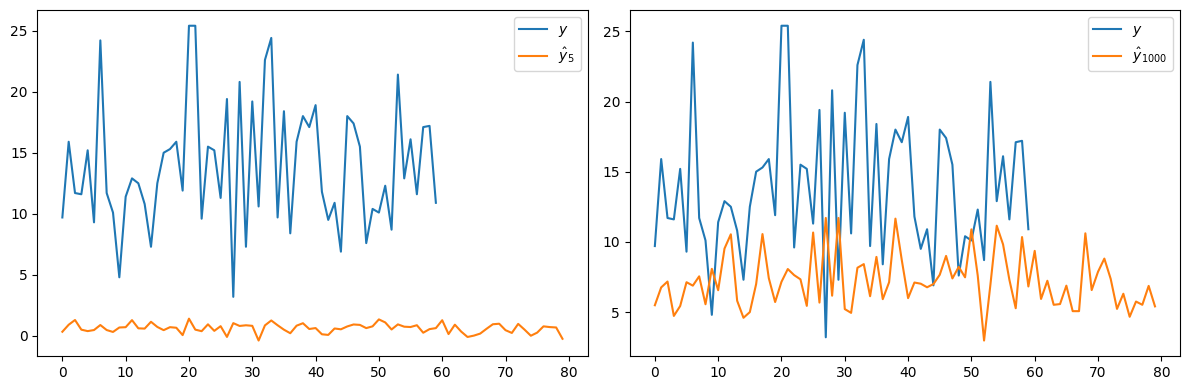

In [191]:
# | code-fold : true
y_pred_5 = model1.predict(x_val)
y_pred_1000 = model2.predict(x_val)

fig, axes = plt.subplots(1,2,figsize = (12, 4))

ax1, ax2 = axes

ax1.plot(y_test, label = r"$y$")
ax1.plot(y_pred_5, label = r"$\hat y_{5}$")
ax1.legend()

ax2.plot(y_test, label = r"$y$")
ax2.plot(y_pred_1000, label = r"$\hat y_{1000}$")
ax2.legend()

fig.tight_layout()
plt.show()


`-` 뭐 epoch를 1000번으로 해도 딱히 성능이 좋아보이지 않음

* 일단 두 model의 성능을 비교해보자

In [194]:
print("model1 : epochs = 5")
print(f'RMSE  : {mean_squared_error(y_val, y_pred_5, squared=False)}')
print(f'MAE   : {mean_absolute_error(y_val, y_pred_5)}')
print("\n-------------------------\n")
print("model1 : epochs = 1000")
print(f'RMSE  : {mean_squared_error(y_val, y_pred_1000, squared=False)}')
print(f'MAE   : {mean_absolute_error(y_val, y_pred_1000)}')

model1 : epochs = 5
RMSE  : 7.343708509578071
MAE   : 6.769834949548357

-------------------------

model1 : epochs = 1000
RMSE  : 2.216046941057742
MAE   : 1.7544673845767975


****

## excercise 2. mobile (분류)

### (1) 데이터 이해 및 준비

In [195]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_churn_simple.csv"
data = pd.read_csv(path)
data['CHURN'] = data['CHURN'].map({'STAY':0, 'LEAVE':1})
data.head()

,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CHURN
0,31953,0,6,313378,161,0,4,0
1,36147,0,13,800586,244,0,6,0
2,27273,230,0,305049,201,16,15,0
3,120070,38,33,788235,780,3,2,1
4,29215,208,85,224784,241,21,1,0


In [197]:
target = 'CHURN'
x = data.drop(target, axis=1)
y = data[target]

`-` 데이터 분할

In [198]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = .2)

`-` scaling

In [201]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)

### (2) 모델링

In [203]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

In [207]:
nf = x_train.shape[1]

In [209]:
y_train.unique()

array([0, 1])

`-` 여기서도 epochs에 따른 모델들 사이 성능 차이 비교

In [216]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [220]:
e = [5,100]

for i in range(2) :
  with tf.device('/device:GPU:0'):
    exec(f"model{i} = Sequential([ Dense(1, input_shape = (nf,), activation = 'sigmoid') ])")
    exec(f"model{i}.compile(optimizer='adam', loss='binary_crossentropy')")
    exec(f"model{i}.fit(x_train,y_train,epochs = {e[i]},verbose=1)")

Epoch 1/5
500/500 [==============================] - 3s 4ms/step - loss: 0.7537
Epoch 2/5
500/500 [==============================] - 1s 2ms/step - loss: 0.7043
Epoch 3/5
500/500 [==============================] - 1s 2ms/step - loss: 0.6776
Epoch 4/5
500/500 [==============================] - 1s 2ms/step - loss: 0.6612
Epoch 5/5
500/500 [==============================] - 1s 2ms/step - loss: 0.6513
Epoch 1/100
500/500 [==============================] - 2s 3ms/step - loss: 0.6921
Epoch 2/100
500/500 [==============================] - 2s 3ms/step - loss: 0.6716
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 0.6589
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 0.6509
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 0.6457
Epoch 6/100
500/500 [==============================] - 1s 2ms/step - loss: 0.6423
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 0.6399
Epoch 8/100
500/500 [=====

In [238]:
train_error_5 = model0.history.history["loss"]
train_error_100  = model1.history.history["loss"]

`-` epoch에 따른 train loss를 살펴본 결과 특정 epoch이후에는 loss값이 변화가 미비하다...

* 대충보니 `epoch = 10`정도만 해도 될 것같음..

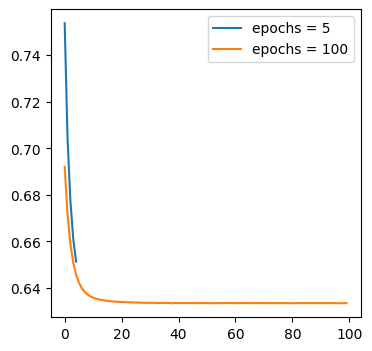

In [248]:
plt.figure(figsize = (4,4))
plt.plot(train_error_5,label = "epochs = 5")
plt.plot(train_error_100,label = "epochs = 100")
plt.legend()
plt.show()

`-` epoch = 10으로 셋팅 후 결과 리포트 작성

In [249]:
model2 = Sequential([ Dense(1, input_shape = (nf,), activation = 'sigmoid') ])
model2.compile(optimizer='adam', loss='binary_crossentropy')
model2.fit(x_train,y_train,epochs = 10,verbose=1)

Epoch 1/10
500/500 [==============================] - 2s 2ms/step - loss: 0.7028
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 0.6771
Epoch 3/10
500/500 [==============================] - 1s 2ms/step - loss: 0.6625
Epoch 4/10
500/500 [==============================] - 1s 2ms/step - loss: 0.6532
Epoch 5/10
500/500 [==============================] - 1s 2ms/step - loss: 0.6472
Epoch 6/10
500/500 [==============================] - 1s 3ms/step - loss: 0.6431
Epoch 7/10
500/500 [==============================] - 1s 3ms/step - loss: 0.6403
Epoch 8/10
500/500 [==============================] - 1s 2ms/step - loss: 0.6384
Epoch 9/10
500/500 [==============================] - 1s 2ms/step - loss: 0.6371
Epoch 10/10
500/500 [==============================] - 1s 2ms/step - loss: 0.6362


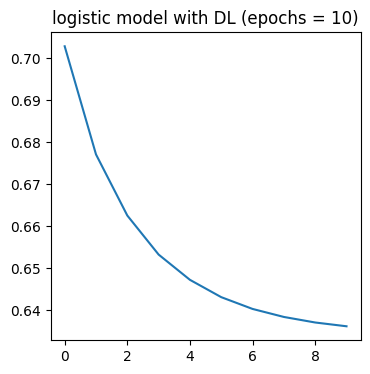

In [252]:
plt.figure(figsize = (4,4))
plt.title("logistic model with DL (epochs = 10)")
plt.plot(model2.history.history["loss"])
plt.show()

In [256]:
y_pred = np.where(model2.predict(x_val)>= 0.5, 1, 0)

print(confusion_matrix(y_val, y_pred))
print('-'*50)
print(classification_report(y_val, y_pred))

125/125 [==============================] - 0s 2ms/step
[[1320  727]
 [ 729 1224]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2047
           1       0.63      0.63      0.63      1953

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000



`-` 최종 결과 시각화

In [257]:
from sklearn.metrics import *
pre = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)

In [268]:
measure = ["precision", "recall", "F1-score", "accuracy"]
value = [pre,recall,f1,acc]

result = pd.DataFrame(value,columns = ["value"])
result["measure"] = measure
fig = result.plot(x = "measure", y = "value", kind = "bar",
            backend = "plotly",color = "measure")

fig.update_yaxes(range = [0.62,0.64])

### summary

`1` epoch을 늘려도 성능이 그렇게 좋지 않음

In [272]:
from keras.optimizers import Adam
Adam?

`2` 아마도 기존에 제공하는 학습률이 너무 작아서 로컬 미니멈에 빠지는 것 같음

* 아래를 통해서 `Adam`에서 기본적으로 제공하는 학습률이 `0.001`임을 확인 가능

```python
from keras.optimizers import Adam
Adam?
```

`3` 또한, 모델 적합시 검증용 데이터를 이용하지 않아 학습시 잘못된 학습을 한 경우에도 그냥 반영하는 것 같음

`4` 생각해볼 수 있는 접근법

* 그렇다면, 학습 시 검증용 데이터를 이용

* 그리고, `epoch`와 `learning_rate`를 적절히 이용한다면..모델 성능을 높일 수 있지 않을까??

* 그리고 은닉층을 여러개 추가한다면???

***

## excercise 3. Boston (회귀)

### (1) 데이터 이해 및 준비

In [273]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv'
data = pd.read_csv(path)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [282]:
target = "medv"

x = data.drop(target, axis = 1)
y= data[target]

`-` 데이터 분할

In [283]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

`-` scaling

In [284]:
# 스케일러 선언
scaler = MinMaxScaler()

# train 셋으로 fitting & 적용
x_train = scaler.fit_transform(x_train)

# validation 셋은 적용만!
x_val = scaler.transform(x_val)

### (2) 모델링

`-` 이번시간에 알아볼 것!

* 학습률은 `0.01`, `activation = "relu"`, `optimizer = "adam"`, `epochs = 50` 고정!

* `validation_split = 0.2로 고정`

* 은닉층과 은닉노드 개수에 따라 어떻게 모델 성능이 변화하는지 비교해보자.

|model|은닉층|각 층에서 은닉노드의 개수|params|
|:---:|:---:|:---:|:---:|
|model1|2|(2,1)|26 + 3 = 29|
|model2|2|(8,1)|104 + 9 = 113|
|model3|2|(8,4,1)|104 + 36 + 5 = 145|



#### import

In [288]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers import Adam

#### `model1` 설계

In [297]:
nf = x_train.shape[1]
lr = 0.01
at = "relu" ## 활성화 함수
e = 50 ## epochs

|model|은닉층|각 층에서 은닉노드의 개수|params|
|:---:|:---:|:---:|:---:|
|model1|2|(2,1)|26 + 3 = 29|
|model2|2|(8,1)|104 + 9 = 113|
|model3|2|(8,4,1)|104 + 36 + 5 = 145|



In [357]:
clear_session()
model1 = Sequential(Dense(2, input_shape =(nf,),activation=at)) ## 첫 번째 은닉층
model1.add(Dense(1,activation=at))

model1.summary() ## 각 층에서 param 개수와 전체 param 개수 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 26        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 29 (116.00 Byte)
Trainable params: 29 (116.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`-`  compile & fit

In [358]:
model1.compile(optimizer = Adam(learning_rate = lr), loss = "mse")

In [359]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [360]:
with tf.device('/device:GPU:0') :
     model1.fit(x_train,y_train,epochs = e, validation_split = 0.2, verbose = 0)

`-` train 및 val error 저장

In [361]:
total_train = pd.DataFrame()
total_val = pd.DataFrame()
model1_train_loss = model1.history.history["loss"]
model1_val_loss = model1.history.history["val_loss"]

total_train.loc[:,0] = model1_train_loss
total_val.loc[:,0] = model1_val_loss

`-` predict

In [362]:
total_pred = pd.DataFrame()
model1_pred = model1.predict(x_val).reshape(-1)
total_pred.loc[:,0] = model1_pred
#total_pred

4/4 [==============================] - 0s 2ms/step


#### model2 설계

|model|은닉층|각 층에서 은닉노드의 개수|params|
|:---:|:---:|:---:|:---:|
|model1|2|(2,1)|26 + 3 = 29|
|model2|2|(8,1)|104 + 9 = 113|
|model3|2|(8,4,1)|104 + 36 + 5 = 145|



In [363]:
model2 = Sequential(Dense(8, input_shape = (nf,), activation = at))

model2.add(Dense(1,activation = at))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 104       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 113 (452.00 Byte)
Trainable params: 113 (452.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`-` compile & fit

In [364]:
model2.compile(optimizer = Adam(learning_rate = lr), loss = "mse")

In [365]:
with tf.device('/device:GPU:0') :
     model2.fit(x_train,y_train,epochs = e, validation_split = 0.2, verbose = 0)

In [366]:
model2_train_loss = model2.history.history["loss"]
model2_val_loss = model2.history.history["val_loss"]

total_train.loc[:,1] = model2_train_loss
total_val.loc[:,1] = model2_val_loss

In [367]:
model2_pred = model2.predict(x_val).reshape(-1)
total_pred.loc[:,1] = model2_pred

4/4 [==============================] - 0s 3ms/step


#### model3 설계

|model|은닉층|각 층에서 은닉노드의 개수|params|
|:---:|:---:|:---:|:---:|
|model1|2|(2,1)|26 + 3 = 29|
|model2|2|(8,1)|104 + 9 = 113|
|model3|3|(8,4,1)|104 + 36 + 5 = 145|

In [368]:
model3 = Sequential(Dense(8, input_shape = (nf,), activation = at))

model3.add(Dense(4, activation = at))

model3.add(Dense(1, activation = at))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (580.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [369]:
model3.compile(optimizer=Adam(learning_rate=lr), loss = "mse")

In [370]:
with tf.device('/device:GPU:0') :
     model3.fit(x_train,y_train,epochs = e, validation_split = 0.2, verbose = 0)

In [371]:
model3_train_loss = model3.history.history["loss"]
model3_val_loss = model3.history.history["val_loss"]

total_train.loc[:,2] = model3_train_loss
total_val.loc[:,2] = model3_val_loss

model3_pred = model3.predict(x_val).reshape(-1)
total_pred.loc[:,2] = model3_pred

4/4 [==============================] - 0s 3ms/step


`-`결과 시각화

|model|은닉층|각 층에서 은닉노드의 개수|params|
|:---:|:---:|:---:|:---:|
|model1|2|(2,1)|26 + 3 = 29|
|model2|2|(8,1)|104 + 9 = 113|
|model3|3|(8,4,1)|104 + 36 + 5 = 145|

In [393]:
total_train.columns = ["model1", "model2","model3"]
total_val.columns = ["model1", "model2","model3"]
total_pred.columns = ["model1", "model2","model3"]

`-` tidydata 생성

In [409]:
# | code-fold : true
total_train2 = total_train.melt(var_name = "model",
                 value_name ="loss")
total_train2["label"] = "train"
total_train2["epochs"] = list(range(1,51))*3


total_val2 = total_val.melt(var_name = "model",
                 value_name ="loss")
total_val2["label"] = "val"
total_val2["epochs"] = list(range(1,51))*3


total1 = pd.concat([total_train2, total_val2],axis = 0)

`-` train, val loss 시각화

In [422]:
fig = total1.plot(x= "epochs", y = "loss",
            color = "label", facet_col = "model",kind = "scatter",
            backend = "plotly", width = 1200, height = 400, opacity=0.5)
fig.show()

`-` train, val loss만 보면 `model2`가 가장 잘 적합된 모델인 것 같다.

`-` test data 예측결과 시각화

In [434]:
total_pred["y_true"] = y_val.reset_index(drop=True)

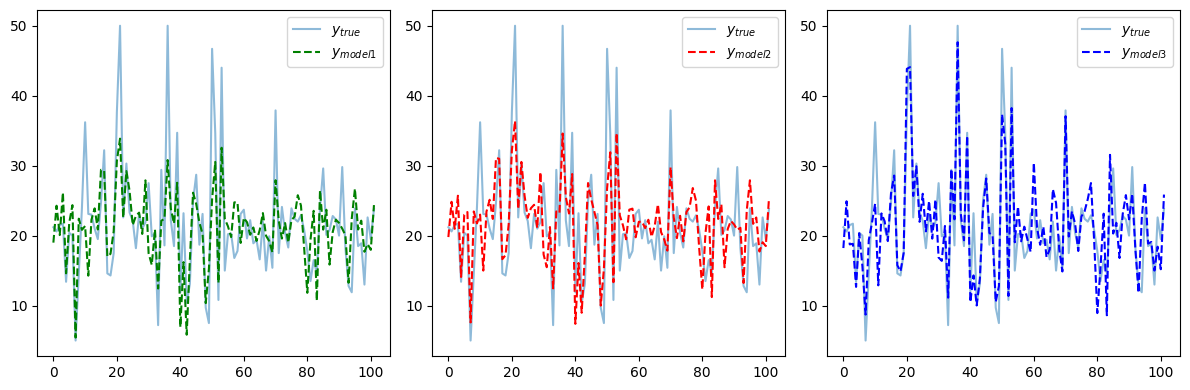

In [445]:
# | code-fold : true
fig, axes = plt.subplots(1,3,figsize = (12,4))

ax1, ax2, ax3 = axes
ax1.plot(total_pred["y_true"], label =  r"$y_{true}$", alpha = 0.5)
ax1.plot(total_pred["model1"],"--g", label =  r"$y_{model1}$")
ax1.legend()

ax2.plot(total_pred["y_true"], label =  r"$y_{true}$", alpha = 0.5)
ax2.plot(total_pred["model2"],"--r", label =  r"$y_{model2}$")
ax2.legend()

ax3.plot(total_pred["y_true"], label =  r"$y_{true}$", alpha = 0.5)
ax3.plot(total_pred["model3"],"--b", label =  r"$y_{model3}$")
ax3.legend()

fig.tight_layout()

`-` test data에 대한 예측결과 `model3`가 가장 잘 예측하고 있는것 같다.

* 근데 이것을 수치적으로 확인하기 위해 `MAE` 수치만 비교해보자.

In [449]:
model1_mae = mean_absolute_error(y_val, model1_pred)
model2_mae = mean_absolute_error(y_val, model2_pred)
model3_mae = mean_absolute_error(y_val, model3_pred)

mae = [model1_mae, model2_mae, model3_mae]
model = ["model1", "model2","model3"]

fig = pd.DataFrame({"model": model,"mae" : mae}).\
      plot(kind = "bar",backend = "plotly",
           x = "model", y= "mae",color = "model",width = 400, height = 400,
              title = "Mean Absolute error by model")
fig.update_yaxes(range = (3,4.5))

### (3) summary

|model|은닉층|각 층에서 은닉노드의 개수|params|
|:---:|:---:|:---:|:---:|
|model1|2|(2,1)|26 + 3 = 29|
|model2|2|(8,1)|104 + 9 = 113|
|model3|3|(8,4,1)|104 + 36 + 5 = 145|

* `epochs, activation, learning_rate, optimizer`를 고정시켜놓고 은닉층의 수와 노드의 수에 따라 예측 성능을 비교해봤음

* 비교결과 `model2`가 가장 학습 데이터에 적합했으나 실제로는 `model3`와 비교해보면 과적합 문제가 의심됨.

* insight1 : 은닉층의 수와 노드의 수 즉, 파라미터 수를 어떻게 조절하냐에 따라서도 모델 성능이 달라질 수 있음!!